# TTA Prediction as a classification task

The classification approach to our problem could be sufficient for some use cases. The classes would be different time intervals (e.g. Wil divide in more than 10 minutes, will divide in 10 to 5 minutes and will divide in less than 5 minutes).

This model might be useful to filter the data at first, and then to apply the regression model. This could avoid it from making very bad decisions!

In [60]:
%matplotlib inline
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
from skimage import measure # to get contours from masks
import sklearn

sns.set_theme()
plt.rc('axes', labelsize=18, titlesize=20) 
plt.rc("legend", fontsize=16)

## Prepare the dataset

Here we split the data points into : "will divide in more than 10 minutes" and "will divide in less than 10 minutes" based on two features : time since bud detection (```time```) and relative surface (```relat_surf```).

In [35]:
os.chdir("D:\Documents\STAGE\Anaphase\Structured")
data = pd.read_csv("Measures_BFf0001_H449pos2_merged.csv", sep=";", comment="#", index_col="idx")
data = data[(data["time_to_anaphase"] >= 0) & (data["time"] > 0)].dropna()

print(data.shape)
data.head()

(1497, 25)


,frame,time,mom_ID,daugh_ID,mom_x,mom_y,daugh_x,daugh_y,mom_surf,daugh_surf,...,daugh_ecc,relat_ecc,mom_circ,daugh_circ,relat_circ,inter_centroid_dist,relat_inter_centroid_distance,anaphase,time_to_anaphase,movie_name
idx,,,,,,,,,,,,,,,,,,,,,
0,18,1,11.0,808.0,371.062921,331.552239,363.365629,323.352941,191.299472,8.534336,...,0.820408,1.023012,0.847407,0.816201,0.963175,10.630146,0.244912,False,32,H449_pos2
0,19,2,11.0,808.0,371.495880,331.623188,363.063983,323.421053,196.299472,11.250034,...,0.830933,0.998219,0.843124,0.852575,1.011209,12.041595,0.274090,False,31,H449_pos2
0,20,3,11.0,808.0,371.800227,331.260870,363.057890,323.047619,196.299472,13.681430,...,0.938263,1.195639,0.843124,0.776800,0.921335,12.041595,0.264806,False,30,H449_pos2
0,21,4,11.0,808.0,370.928592,331.567164,362.200747,323.142857,192.583774,14.965732,...,0.856876,1.053357,0.872175,0.920806,1.055758,11.313708,0.252302,False,29,H449_pos2
0,22,5,11.0,808.0,372.133561,331.000000,363.010271,322.904762,193.015171,16.397129,...,0.925441,1.101654,0.811349,0.861788,1.062168,12.727922,0.281578,False,28,H449_pos2


In [38]:
from sklearn.model_selection import train_test_split

features = ["daugh_per", "time"]

# remove time 0 and relat_surf 0 since they are conventions and might affect performances
data_biv = data[(data[features[0]] > 0)].dropna()

# center and standardize observations
for f in features:
    data_biv[f] = (data_biv[f] - data_biv[f].mean()) / data_biv[f].std()
    
# prepare the classification labels (0 -> TTA > n minutes ; 1 -> TTA <= n minutes)
threshold = 6
threshold_TTA = lambda x: 1 if x <= threshold else 0
data_biv["TTA_binary"] = data_biv["time_to_anaphase"].apply(threshold_TTA)

X, y = data_biv[features].values, data_biv["TTA_binary"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

plot = False
if plot:
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.scatter(data_biv[(data_biv["TTA_binary"] == 1)]["time"], data_biv[(data_biv["TTA_binary"] == 1)]["relat_surf"], c="g", label=f"TTA <= {threshold}")
    ax.scatter(data_biv[(data_biv["TTA_binary"] == 0)]["time"], data_biv[(data_biv["TTA_binary"] == 0)]["relat_surf"], c="r", label=f"TTA > {threshold}")
    ax.legend()
    ax.set_xlabel("time")
    ax.set_ylabel("relative surface")

(748, 2) (749, 2) (748,) (749,)


## 1. $(t, RS_t) \mapsto \mathbb{1}_{TTA \leq 12}(\cdot)$

As usual, we first test the linear model as a first approach.

### 1.1 First training and evaluation

Accuracy on the train set: 0.8582887700534759.


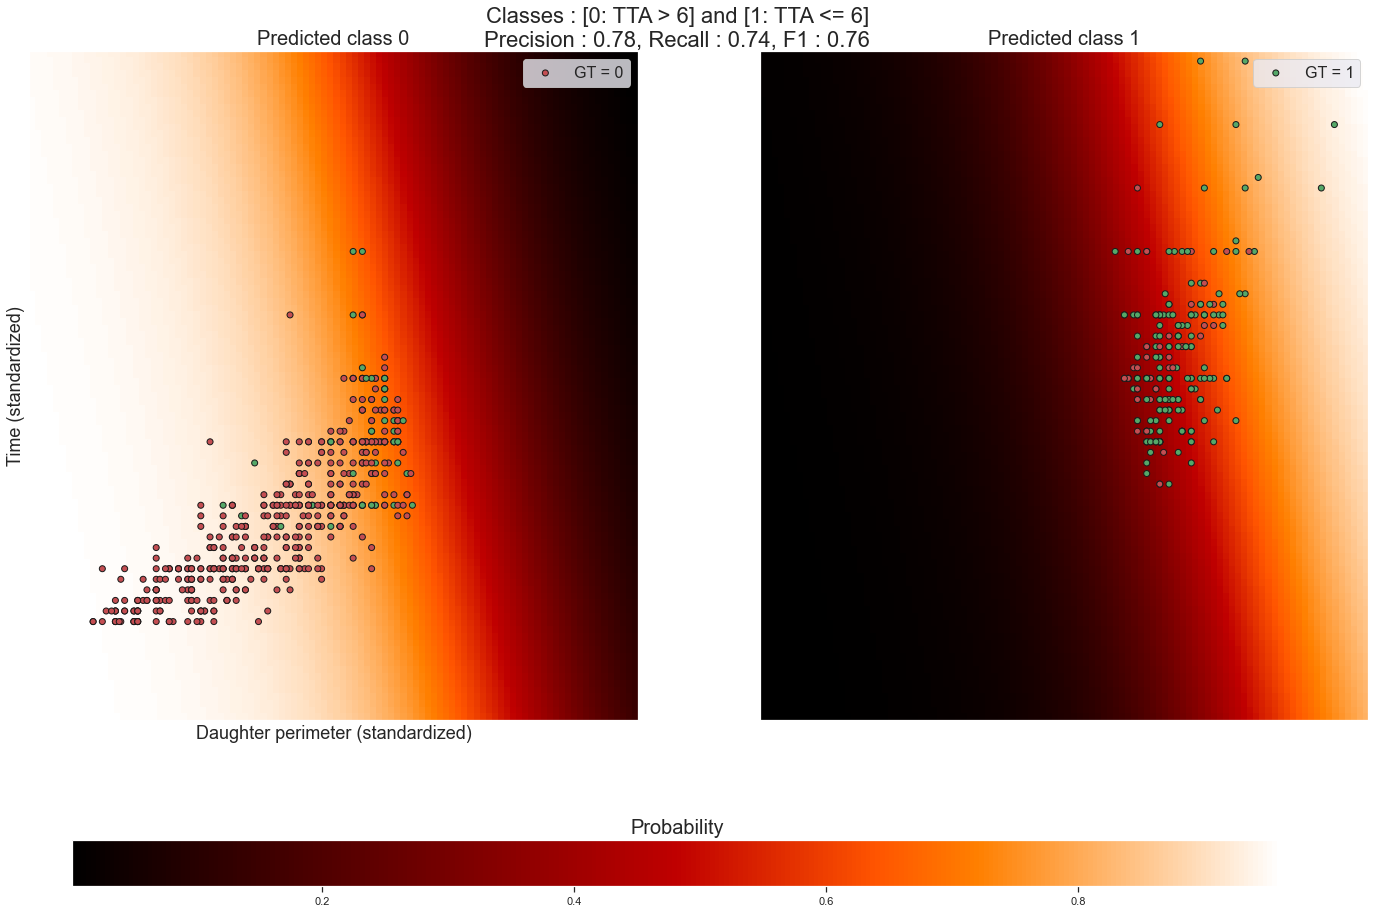

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import precision_score, recall_score, f1_score

lm = LogisticRegression().fit(X_train, y_train)
# lm = RandomForestClassifier().fit(X_train, y_train)

print(f"Accuracy on the train set: {lm.score(X_test, y_test)}.")

plot = True
if plot:
    import matplotlib as mpl
    mpl.rc('image', cmap='gist_heat')
    n_classes = 2
    fig = plt.figure(figsize=(2 * 12, 13))
    plt.subplots_adjust(bottom=.2, top=.95)
    
    xx = np.linspace(-2, 2, 100)
    yy = np.linspace(-2, 2, 100).T
    xx, yy = np.meshgrid(xx, yy)
    Xfull = np.c_[xx.ravel(), yy.ravel()]
    
#     y_pred = lm.predict(X)
    y_pred = lm.predict(X_test)  # threshold = 0.5 I guess

#     precision, recall, f1 = precision_score(y, y_pred), recall_score(y, y_pred), f1_score(y, y_pred)
    precision, recall, f1 = precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)

    # View probabilities:
    probas = lm.predict_proba(Xfull)
    n_classes = np.unique(y_pred).size
    for k in range(n_classes):
        plt.subplot(1, n_classes, k + 1)
        plt.suptitle(f"Classes : [0: TTA > {threshold}] and [1: TTA <= {threshold}]\nPrecision : {round(precision, 2)}, Recall : {round(recall, 2)}, F1 : {round(f1, 2)}",
                    fontsize=22)
        plt.title("Predicted class %d" % k)
        if k == 0:
            plt.xlabel("Daughter perimeter (standardized)", fontsize=18)
            plt.ylabel("Time (standardized)", fontsize=18)
        imshow_handle = plt.imshow(probas[:, k].reshape((100, 100)),
                                   extent=(-3, 3, -2.5, 4.1), origin='lower')
        plt.xticks(())
        plt.yticks(())
        idx = (y_pred == k)
        label_to_color = lambda l: "g" if l == 1 else "r"  # color in green the 1-label points and red the 0-label points
        vlabel_to_colors = np.vectorize(label_to_color)
        if idx.any():
#             colors = vlabel_to_colors(y[idx])
#             plt.scatter(X[idx, 0], X[idx, 1], marker='o', c=colors, edgecolor='k', label=f"GT = {k}")
            colors = vlabel_to_colors(y_test[idx])
            plt.scatter(X_test[idx, 0], X_test[idx, 1], marker='o', c=colors, edgecolor='k', label=f"GT = {k}")
            plt.legend()

            
    # colorbar
    ax = plt.axes([0.15, 0.04, 0.7, 0.05])
    plt.title("Probability", fontsize=20)
    plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')

    plt.show()
    fig.savefig("D:/Documents/STAGE/Rapport/Images/tta_classification_logreg.pdf", format="pdf")

### 1.2 K-fold cross-validation

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import RepeatedKFold

models = [LogisticRegression(), RandomForestClassifier(max_depth=5, n_estimators=100), DecisionTreeClassifier(), AdaBoostClassifier(), KNeighborsClassifier(n_neighbors=20)]

X, y = data_biv[features].values, data_biv["TTA_binary"].values
n_folds, n_repeats = 2, 100
kf = RepeatedKFold(n_splits=n_folds, n_repeats=n_repeats)

metrics = []
for k, model in enumerate(models):
    precision, recall, f1 = [], [], []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        blm = model.fit(X_train, y_train)
        y_pred = blm.predict(X_test)
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))
        metrics.append({"model": k, "precision": precision_score(y_test, y_pred), "recall": recall_score(y_test, y_pred), "f1": f1_score(y_test, y_pred)})
    
    precision, recall, f1 = np.array(precision), np.array(recall), np.array(f1)    
    
    print(f"Modele: {model} evaluated on {n_folds}-fold cross-validation ({n_repeats} repeats).")
    print(f"Precision = {round(precision.mean(), 2)} +- {round(precision.std(), 2)}")
    print(f"Recall = {round(recall.mean(), 2)} +- {round(recall.std(), 2)}")
    print(f"F1 = {round(f1.mean(), 2)} +- {round(f1.std(), 2)}")
    print("\n")
    
metrics = pd.DataFrame(metrics)

Modele: LogisticRegression() evaluated on 2-fold cross-validation (100 repeats).
Precision = 0.77 +- 0.03
Recall = 0.72 +- 0.03
F1 = 0.74 +- 0.02


Modele: RandomForestClassifier(max_depth=5) evaluated on 2-fold cross-validation (100 repeats).
Precision = 0.77 +- 0.03
Recall = 0.73 +- 0.03
F1 = 0.75 +- 0.02


Modele: DecisionTreeClassifier() evaluated on 2-fold cross-validation (100 repeats).
Precision = 0.68 +- 0.03
Recall = 0.64 +- 0.04
F1 = 0.66 +- 0.03


Modele: AdaBoostClassifier() evaluated on 2-fold cross-validation (100 repeats).
Precision = 0.75 +- 0.04
Recall = 0.72 +- 0.05
F1 = 0.74 +- 0.02


Modele: KNeighborsClassifier(n_neighbors=20) evaluated on 2-fold cross-validation (100 repeats).
Precision = 0.78 +- 0.03
Recall = 0.73 +- 0.04
F1 = 0.75 +- 0.02




Text(0.5, 0.98, "Models' performances on classification with time threshold == 12 min.")

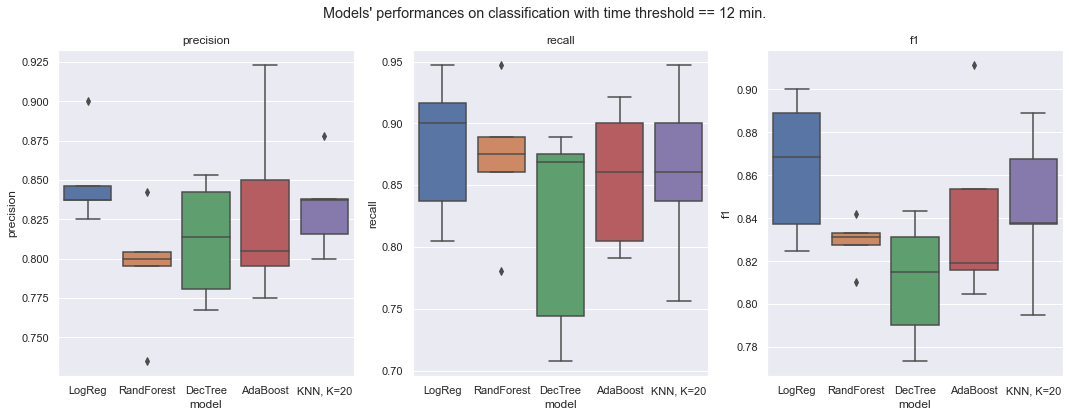

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
models = [LogisticRegression(), RandomForestClassifier(max_depth=5, n_estimators=750), DecisionTreeClassifier(), AdaBoostClassifier(), KNeighborsClassifier(n_neighbors=20)]

names = ["LogReg", "RandForest", "DecTree", "AdaBoost", "KNN, K=20"]
for i, metric in enumerate(["precision", "recall", "f1"]):
    sns.boxplot(x="model", y=metric, data=metrics, ax=ax[i])
    ax[i].set_xticks(np.arange(0, len(models)))
    ax[i].set_xticklabels(names)
    ax[i].set_title(metric)
fig.suptitle("Models' performances on classification with time threshold == 12 min.")

## 2. TTA Regression after classification

We test if performing the TTA regression after having done classification could help to improve the regression predictions, by avoiding to make very bad predictions inter alia.
We train a regression model on the observations that are close to anaphase only (let's call it a late regressor). Then we identify when a cell is "late" using the classification model, and make predictions at this point only. We compare the MSE of such a model with the performances of a general regressor model (predictions on the late cells only, or not).

### 2.1 Motivation : TTA linear regression is more accurate on the smaller intervall

The first cross-validation suggests that the prediction is more accurate (in terms of RMSE) than when we train a model on the full timeline (between 0 and 50 minutes) and make predictions... What could be the cause of that ? Could it be artificial (artefact due to the fact that we predit on a smaller time interval -> No otherwise a model trained on the full timeline would still have performed better on this time interval than on the evaluation dataset of the full timeline, which isn't the case) ? Is it because we dedicated a model to train on this smaller interval (then, if the dataset isn't really linear, training a linear model on the full would reduce the performances compared with a model dedicated to a smaller time interval -> Good reason) ?
A linear model trained on data from the full timeline performs indeed worse than the model which was trained on only the late observations, when we evaluate them on the same evaluation set (that the late model didn't during training, and that the full model saw potentially a bit):
- RMSE(full timeline model on late observations only) = 5.67 +- 1.38 minute (kind of the same as obtained when training and evaluating on full dataset).
- RMSE(late time model on late observations only) = 3.89 +- 0.53 minute.

Conversely the full timeline model performs better on the full timeline dataset than the late time model (RMSE(late model on full timeline evaluation set) is 10.69 +- 2.06 minutes).

It could only be possible if the function $(t, RS_t) \mapsto TTA_t$ is not really linear. 

So here we demonstrated the benefits of training and predicting on only a subpart of the timeline (e.g. the last moment) with a dedicated model. It is not because the predictions at those times are easier (otherwise the full timeline model would have performed better on this time interval than on the full time interval, which isn't really the case : 5.67 +- 1.38 vs. 6.1 RMSE), but because a model dedicated to this time interval (trained and evaluated on observations of this smaller time interval) performs better on it. This must be due to the fact that the data distribution isn't perfectly linear.

In [256]:
# train a late regressor : only on cells which will divide in less than 12 minutes.
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold

# reload data
data = pd.read_csv("Analysis_BF_f0001-1-100.1.csv", sep=";", comment="#", index_col="idx")
data = data[data["time_to_anaphase"] >= 0]

features = ["time", "relat_surf"]

# The first linear regression is trained on the full timeline
X_full, y_full = data_biv[features].values, data_biv["time_to_anaphase"].values

# The second is trained only on the last part of the timeline (12 -> 0 minutes before anaphase)
X, y = data_biv[data_biv["time_to_anaphase"] <= threshold][features].values, data_biv[data_biv["time_to_anaphase"] <= threshold]["time_to_anaphase"].values

# cross validation
n_iter = 10
kf, kff = KFold(n_splits=n_iter), KFold(n_splits=n_iter)

rmse, scores, scores_full, rmse_full = [], [], [], []
for (tr_idx_full, te_idx_full), (train_idx, test_idx) in zip(kff.split(X_full), kf.split(X)):
    X_train, X_test, X_tr_full, X_te_full = X[train_idx], X[test_idx], X_full[tr_idx_full], X_full[te_idx_full]
    y_train, y_test, y_tr_full, y_te_full = y[train_idx], y[test_idx], y_full[tr_idx_full], y_full[te_idx_full]
    blm_full = LinearRegression().fit(X_tr_full, y_tr_full) # fit a model on the full timeline and predict on the late observ
    blm = LinearRegression().fit(X_train, y_train) # fit a model on juste the late observations (TTA < 12)
    scores.append(blm.score(X_test, y_test))
    scores_full.append(blm_full.score(X_test, y_test))
    rmse.append(np.sqrt(((y_test - blm.predict(X_test)) ** 2).mean()))
    rmse_full.append(np.sqrt(((y_test - blm_full.predict(X_test)) ** 2).mean()))
rmse = np.array(rmse)
scores = np.array(scores)
rmse_full, scores_full = np.array(rmse_full), np.array(scores_full)

print(f"R^2 of the late model on {n_iter} folds : {scores}")
print(f"Mean R^2 on {n_iter}-fold cross-validation : {round(scores.mean(), 2)} +- {round(scores.std(), 2)}.\n")

print(f"RMSE of the late model on {n_iter} folds : {rmse}")
print(f"Mean RMSE on {n_iter}-fold cross-validation : {round(rmse.mean(), 2)} +- {round(rmse.std(), 2)} min.")

print(f"R^2 of the full timeline model on {n_iter} folds : {scores_full}")
print(f"Mean R^2 on {n_iter}-fold cross-validation : {round(scores_full.mean(), 2)} +- {round(scores_full.std(), 2)}.\n")

print(f"RMSE of the full timeline model on {n_iter} folds : {rmse_full}")
print(f"Mean RMSE on {n_iter}-fold cross-validation : {round(rmse_full.mean(), 2)} +- {round(rmse_full.std(), 2)} min.")

plot = True
if plot:
    %matplotlib qt
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    time, rs = X[:, 0], X[:, 1]
    ax.scatter(time, rs, y, ".b", label="Observations")
    ax.scatter(time, rs, blm.predict(X), "+r", label="Late LR")
#     ax.scatter(time, rs, blm_full.predict(X), "+g", label="Full timeline LR")  # linear reg trained on full timeline
    
    ax.legend()

    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.set_zlabel('TTA (min)')

R^2 of the late model on 10 folds : [ 0.35106875  0.45027559  0.15162204  0.49861322  0.31219633 -0.12691285
  0.46615159  0.55557953  0.34091553  0.53454186]
Mean R^2 on 10-fold cross-validation : 0.35 +- 0.2.

RMSE of the late model on 10 folds : [3.88929138 3.72196926 4.44698665 3.41867311 4.16325024 5.12526473
 3.52760632 3.34654985 3.87111088 3.37913482]
Mean RMSE on 10-fold cross-validation : 3.89 +- 0.53 min.
R^2 of the full timeline model on 10 folds : [ 0.11083629 -0.38439266 -1.64904549 -0.09474664 -1.29238332 -1.41109614
 -0.16920598  0.33326127  0.12081504  0.19767716]
Mean R^2 on 10-fold cross-validation : -0.42 +- 0.7.

RMSE of the full timeline model on 10 folds : [4.5526263  5.90649599 7.85806912 5.05158828 7.60053023 7.49684274
 5.22055469 4.09900183 4.47100543 4.4364928 ]
Mean RMSE on 10-fold cross-validation : 5.67 +- 1.38 min.


### 2.2 Implementation of the method

In the previous section, we demonstrated that the regression of TTA on the last time interval can be more accurate than the regression on the full time interval. We manually selected the observations for which the TTA was inferior to 12 minutes, in other words we manually did the classification task based on the ground truth. In practice we will use a logistic regression model to classify the unseen observations based on their features $(t, RS_t)$. 

We see that the method could work and improve the predictions performances a lot (regarding TTA regression) but at the cost of drastically reducing the number of cells that we predict. The predictions made by a model trained on the full timeline are worse if the model is linear (RMSE 3.55 +- 2.65 min on 10-fold cross-validation) but when KNeighborsRegressor is used the performances are comparable with those of the linear model trained on the late observations only (RMSE(KNN full time) = 2.6 +- 1.5 min vs. RMSE(LinReg Late) = 2.42 +- 1.35 min).

In [9]:
from sklearn.model_selection import train_test_split

# reload data
data = pd.read_csv("Analysis_BF_f0001-1-100.1.csv", sep=";", comment="#", index_col="idx")
data = data[data["time_to_anaphase"] >= 0]

features = ["time", "relat_surf"]

# remove time 0 and relat_surf 0 since they are conventions and might affect performances
data_biv = data[(data[features[0]] > 0) & (data[features[1]] > 0)].dropna()

# center and standardize observations
for f in features:
    data_biv[f] = (data_biv[f] - data_biv[f].mean()) / data_biv[f].std()
    
# prepare the classification labels (0 -> TTA > n minutes ; 1 -> TTA <= n minutes)
threshold = 12
threshold_TTA = lambda x: 1 if x <= threshold else 0
data_biv["TTA_binary"] = data_biv["time_to_anaphase"].apply(threshold_TTA)

# The classificaiton model is trained on the full timeline
X_full, y_full = data_biv[features].values, data_biv[["TTA_binary", "time_to_anaphase"]].values
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, train_size=0.9)
y_train_full_bin, y_train_full_reg, y_test_full_bin, y_test_full_reg = y_train_full[:, 0], y_train_full[:, 1], y_test_full[:, 0], y_test_full[:, 1]

print(X_train_full.shape, y_train_full_reg.shape)

# The regression model is trained only on the last part of the timeline (12 -> 0 minutes before anaphase)
X_train_late, X_test_late = X_train_full[y_train_full_reg <= threshold], X_test_full[y_test_full_reg <= threshold]
y_train_late, y_test_late = y_train_full_reg[y_train_full_reg <= threshold], y_test_full_reg[y_test_full_reg <= threshold]

print(X_train_full.shape, X_test_full.shape, X_train_late.shape, X_test_late.shape, y_train_full_bin.shape, y_test_full_bin.shape, y_train_late.shape, y_test_late.shape)

(384, 2) (384,)
(384, 2) (43, 2) (178, 2) (20, 2) (384,) (43,) (178,) (20,)


#### 2.2.1 Cross-validation

In [12]:
# from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, KFold

# cross validation
n_iter = 10
kf = KFold(n_splits=n_iter)

# reload data
data = pd.read_csv("Analysis_BF_f0001-1-100.1.csv", sep=";", comment="#", index_col="idx")
data = data[data["time_to_anaphase"] >= 0]

features = ["time", "relat_surf"]

# remove time 0 and relat_surf 0 since they are conventions and might affect performances
data_biv = data[(data[features[0]] > 0) & (data[features[1]] > 0)].dropna()

# center and standardize observations
for f in features:
    data_biv[f] = (data_biv[f] - data_biv[f].mean()) / data_biv[f].std()

# prepare the classification labels (0 -> TTA > n minutes ; 1 -> TTA <= n minutes)
threshold = 12
threshold_TTA = lambda x: 1 if x <= threshold else 0
data_biv["TTA_binary"] = data_biv["time_to_anaphase"].apply(threshold_TTA)

# The classificaiton model is trained on the full timeline
X_full, y_full = data_biv[features].values, data_biv[["TTA_binary", "time_to_anaphase"]].values

rmse, scores = [], []
for train_idx, test_idx in kf.split(X_full):

    X_train_full, X_test_full, y_train_full, y_test_full = X_full[train_idx], X_full[test_idx], y_full[train_idx], y_full[test_idx]
    y_train_full_bin, y_train_full_reg, y_test_full_bin, y_test_full_reg = y_train_full[:, 0], y_train_full[:, 1], y_test_full[:, 0], y_test_full[:, 1]

    # The regression model is trained only on the last part of the timeline (12 -> 0 minutes before anaphase)
    X_train_late, X_test_late = X_train_full[y_train_full_reg <= threshold], X_test_full[y_test_full_reg <= threshold]
    y_train_late, y_test_late = y_train_full_reg[y_train_full_reg <= threshold], y_test_full_reg[y_test_full_reg <= threshold]
    
    # train models
    clf = LogisticRegression().fit(X_train_full, y_train_full_bin)
    full_lm = KNeighborsRegressor().fit(X_train_full, y_train_full_reg)
    late_lm = LinearRegression().fit(X_train_late, y_train_late)
    
    # 1. classification step
    clf_pred = clf.predict_proba(X_test_full)
    
    # 2. TTA regression on the cells which will divide in less than 12 minutes for sur
    classif_thresh, reg_pred = 0.99, []
    for features, gt, p in zip(X_test_full, y_test_full_bin, clf_pred):
        if p[1] > classif_thresh: # TP -> we predict TTA with late_lm
            reg_pred.append(late_lm.predict(features.reshape(1, -1))[0])
        else:
            reg_pred.append(np.nan)
    reg_pred = np.array(reg_pred)

    losses = (reg_pred[~np.isnan(reg_pred)] - y_test_full_reg[~np.isnan(reg_pred)]) ** 2
        
    if losses.shape[0] > 0:
        print(f"Kept observations : {round(losses.size / clf_pred.size * 100)} %.")
        rmse.append(np.sqrt(losses.mean()))
        
rmse = np.array(rmse)

print(f"RMSE obtained on {n_iter}-fold cross-validation: {rmse}")
print(f"Mean RMSE on the pipeline with threshold {threshold} min and proba threshold {classif_thresh}: {round(rmse.mean(), 2)} +- {rmse.std()} min.")

plot = False
if plot:
    %matplotlib qt
    from mpl_toolkits.mplot3d import Axes3D
    
    xx = np.linspace(-2, 2, 100)
    yy = np.linspace(-2, 2, 100).T
    xx, yy = np.meshgrid(xx, yy)
    Xfull = np.c_[xx.ravel(), yy.ravel()]
    plane = late_lm.predict(Xfull)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    time, rs = X_test_full[:, 0], X_test_full[:, 1]
    print(time.shape, rs.shape)
    ax.scatter(xx, yy, plane)
    ax.scatter(time, rs, y_test_full_reg, ".b", label="Observations")
    ax.scatter(time[~np.isnan(reg_pred)], rs[~np.isnan(reg_pred)], reg_pred[~np.isnan(reg_pred)], "+r", label="Late LR")    
    ax.legend()

    ax.set_xlabel(features[0])
    ax.set_ylabel(features[1])
    ax.set_zlabel('TTA (min)')

Kept observations : 2 %.
Kept observations : 6 %.
Kept observations : 2 %.
Kept observations : 3 %.
Kept observations : 10 %.
Kept observations : 2 %.
Kept observations : 1 %.
Kept observations : 4 %.
Kept observations : 5 %.
RMSE obtained on 10-fold cross-validation: [2.6507666  3.11257613 2.37409375 1.46101189 5.83091253 1.96373512
 0.92482509 1.49380181 1.95422528]
Mean RMSE on the pipeline with threshold 12 min and proba threshold 0.99: 2.42 +- 1.3584099235159883 min.
